In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr, shapiro
from scipy.stats import mannwhitneyu, shapiro, ttest_ind, f_oneway, kruskal
import datetime as dt
from scipy.stats import chi2_contingency

In [ ]:
df = pd.read_csv('ecom_yl.csv', sep=',', encoding='utf-8', skipinitialspace=True)
# названия столбцов привести в соответствии с PEP8
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(10)

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN
5,271758921583,United States,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40.0,2019-05-02,5,4,8,NaN,NaN,NaN,NaN
6,425357155257,United States,Android,социальные сети,2019-05-02 16:32:29,2019-05-02 16:55:30,1381.0,2019-05-02,5,4,16,NaN,NaN,NaN,NaN
7,768721432035,Frаnce,Mac,реклама у блогеров,2019-05-02 10:21:30,2019-05-02 10:51:54,1824.0,2019-05-02,5,4,10,NaN,NaN,NaN,NaN
8,177410811849,Unjted States,Android,социальные сети,2019-05-03 18:43:49,2019-05-03 19:30:52,2823.0,2019-05-03,5,5,19,NaN,NaN,NaN,NaN
9,337713702816,United States,iPhone,реклама у блогеров,2019-05-03 19:48:35,2019-05-03 20:16:10,1655.0,2019-05-03,5,5,20,NaN,NaN,NaN,NaN


# **Исследовательский анализ данных и предобработка**

## Пропуски в данных

Пропуски в столбцах order_dt, revenue, payment_type, promo_code обьясняются тем,
что не все пользователи в результате посещения сайта совершают покупку, так что эти пропуски заполнять мы не будем.
Пропуски в столбцах region, device, channel незначительные для наших данных, всего лишь 1%, поэтому мы просто удалим эти строки

In [ ]:
# проверить данные на пропуски и заполнить их при необходимости.
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
user_id,0.000000
region,1.284585
device,1.284585
channel,1.284585
session_start,0.000000
session_end,0.000000
sessiondurationsec,0.000000
session_date,0.000000
month,0.000000
day,0.000000


In [ ]:
print(f'Изначальный размер датасета {df.shape}')
df = df.dropna(subset=['region', 'device', 'channel'])
print(f"После удаления пропусков {df.shape}")
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
print(missing_value_df)

Изначальный размер датасета (1012, 15)
После удаления пропусков (999, 15)
                    percent_missing
user_id                    0.000000
region                     0.000000
device                     0.000000
channel                    0.000000
session_start              0.000000
session_end                0.000000
sessiondurationsec         0.000000
session_date               0.000000
month                      0.000000
day                        0.000000
hour_of_day                0.000000
order_dt                  72.272272
revenue                   72.272272
payment_type              72.272272
promo_code                72.272272


## Тип данных столбцов

In [ ]:
# перевести тип данных столбцов с датой и временем в соответствующий формат при необходимости
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])
df['session_date'] = pd.to_datetime(df['session_date'])
df['order_dt'] = pd.to_datetime(df['order_dt'])
df.dtypes

user_id                        int64
region                        object
device                        object
channel                       object
session_start         datetime64[ns]
session_end           datetime64[ns]
sessiondurationsec           float64
session_date          datetime64[ns]
month                          int64
day                            int64
hour_of_day                    int64
order_dt              datetime64[ns]
revenue                      float64
payment_type                  object
promo_code                   float64
dtype: object

## Обработка дубликатов

In [ ]:
# Смотрим на адекватность данных (например, что нет дня недели под номеров 8 или месяца с номером 22), выявляем неявные дубликаты
for column in df.columns:
  print(f'{column} {set(df[column])}')

user_id {967324426242, 705829990404, 768710666, 62638231562, 211508838415, 634167957523, 427535919123, 34819346453, 1669414933, 564092033044, 254782154776, 269644916759, 319750791188, 656876036120, 784827654174, 26695370783, 873773748256, 614186616862, 70714916898, 879281375267, 532157331491, 333379827757, 628579663918, 334783148079, 265806647343, 158538625073, 357699967026, 773808879664, 827101913137, 660481970221, 408519737399, 593992527931, 498456178749, 921538146366, 187367217216, 230062749766, 53311277127, 375107385414, 59085510728, 917285763144, 569088782411, 442512894030, 289471230031, 346620457038, 380388145233, 870999437394, 759845816404, 265040353365, 384716146775, 55762393176, 848193144919, 151051511897, 323207942235, 158410647644, 87128524893, 562120912990, 470782333023, 487404654687, 378901880930, 618194172003, 714643798116, 301556224101, 604902740068, 344878975077, 826254348390, 600141973606, 812137373800, 696153475179, 756421048432, 759180267632, 522967910514, 8976098571

In [ ]:
# обработка неявных дубликатов
reg = {'France': ['France', 'Frаnce', 'Franсe', 'Frаncе'], 'Germany': ['Germany', 'germany'], 'UK': ['UК', 'UK'], 'United States': ['United States', 'Unjted States']}
for elem in reg.keys():
  df.loc[df['region'].isin(reg[elem]), 'region'] = elem
df.loc[df['device'] == 'android', 'device'] = 'Android'
df.loc[df['channel'] == 'контексная реклама', 'channel'] = 'контекстная реклама'

In [ ]:

# обработка данных на дубликаты
duplicateRows = df[df.duplicated()]
print(duplicateRows)
df = df.drop_duplicates().reset_index(drop=True)

          user_id         region   device             channel  \
68      768710666  United States   iPhone  реклама у блогеров   
196  134214602428  United States  Android     социальные сети   

          session_start         session_end  sessiondurationsec session_date  \
68  2019-05-17 18:24:36 2019-05-17 18:28:05               209.0   2019-05-17   
196 2019-06-11 02:35:48 2019-06-11 03:45:47              4199.0   2019-06-11   

     month  day  hour_of_day            order_dt  revenue     payment_type  \
68       5    5           18 2019-05-17 18:24:36   9999.0  Mobile payments   
196      6    2            3 2019-06-11 02:35:48   4999.0  Mobile payments   

     promo_code  
68     0.862715  
196    1.000000  


Так как у нас всего два дубликата мы можем их удалить.

## Обработка выбросов

Обрабатываем выбросы в столбце sessiondurationsec, т.к. длительность сессии зависит от того
насколько пользователю удобно сидеть на сайте, а это зависит от девайса, то именно по этому столбцу мы обрабатываем выбросы

In [ ]:
devices = list(set(df['device']))
sigma_sessiondurationsec = df['sessiondurationsec'].std()
for device in devices:
  med = df.loc[df['device'] == device, 'sessiondurationsec'].median()
  df.loc[(df['device'] == device) & (df['sessiondurationsec'] < (med - 3 * sigma_sessiondurationsec)) | (df['device'] == device) & (df['sessiondurationsec'] > (med + 3 * sigma_sessiondurationsec)), 'sessiondurationsec'] = med


Обрабатываем выбросы в столбце revenue, сумма покупки может зависеть от региона, поэтому с помощью этого столбца обрабатываем выбросы
Есть пользователи, которые совершали покупки на сумму 100 тыс., это реальная покупка,
она может не являться опечаткой, но чтобы эта строка не выбивалась из наших данных, мы все равно её обработаем

In [ ]:
regions = list(set(df['region']))
sigma_revenue = df['revenue'].std()
for region in regions:
  med = df.loc[df['region'] == region, 'revenue'].median()
  df.loc[(df['region'] == region) & (df['revenue'] < (med - 3 * sigma_revenue)) | (df['region'] == region) & (df['revenue'] > (med + 3 * sigma_revenue)), 'revenue'] = med


## Добавление столбцов

In [ ]:
# добавить столбец итоговой суммой покупки с учетом применения промокода на скидку 10%
df['amount_including_discount'] = np.where(df['promo_code'] > 0, df['revenue'] * 0.9, df['revenue'])

# добавить столбец с указанием времени суток визита (утро 06:00-09:59, день 10:00-16:59, вечер 17:00-21:59, ночь 22:00-05:59)
def times_of_day(x):
  if 6 <= x <= 9:
    return 'утро'
  elif 10 <= x <= 16:
    return 'день'
  elif 17 <= x <= 21:
    return 'вечер'
  return 'ночь'
df['times_of_day'] = df['hour_of_day'].apply(times_of_day)

# добавить столбец “payer” с информацией о том, является ли пользователь платящим или нет.
df_paying_clients = df.where(df['revenue'] > 0).dropna()
user_payer = list(df_paying_clients['user_id'])
df['payer'] = np.where(df['user_id'].isin(user_payer), 'yes', 'no')
df.head(10)

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,amount_including_discount,times_of_day,payer
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,ночь,yes
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN,утро,no
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN,ночь,no
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN,вечер,no
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN,день,no
5,271758921583,United States,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40.0,2019-05-02,5,4,8,NaT,NaN,NaN,NaN,NaN,утро,no
6,425357155257,United States,Android,социальные сети,2019-05-02 16:32:29,2019-05-02 16:55:30,1381.0,2019-05-02,5,4,16,NaT,NaN,NaN,NaN,NaN,день,no
7,768721432035,France,Mac,реклама у блогеров,2019-05-02 10:21:30,2019-05-02 10:51:54,1824.0,2019-05-02,5,4,10,NaT,NaN,NaN,NaN,NaN,день,no
8,177410811849,United States,Android,социальные сети,2019-05-03 18:43:49,2019-05-03 19:30:52,2823.0,2019-05-03,5,5,19,NaT,NaN,NaN,NaN,NaN,вечер,no
9,337713702816,United States,iPhone,реклама у блогеров,2019-05-03 19:48:35,2019-05-03 20:16:10,1655.0,2019-05-03,5,5,20,NaT,NaN,NaN,NaN,NaN,вечер,no


## Графический анализ данных

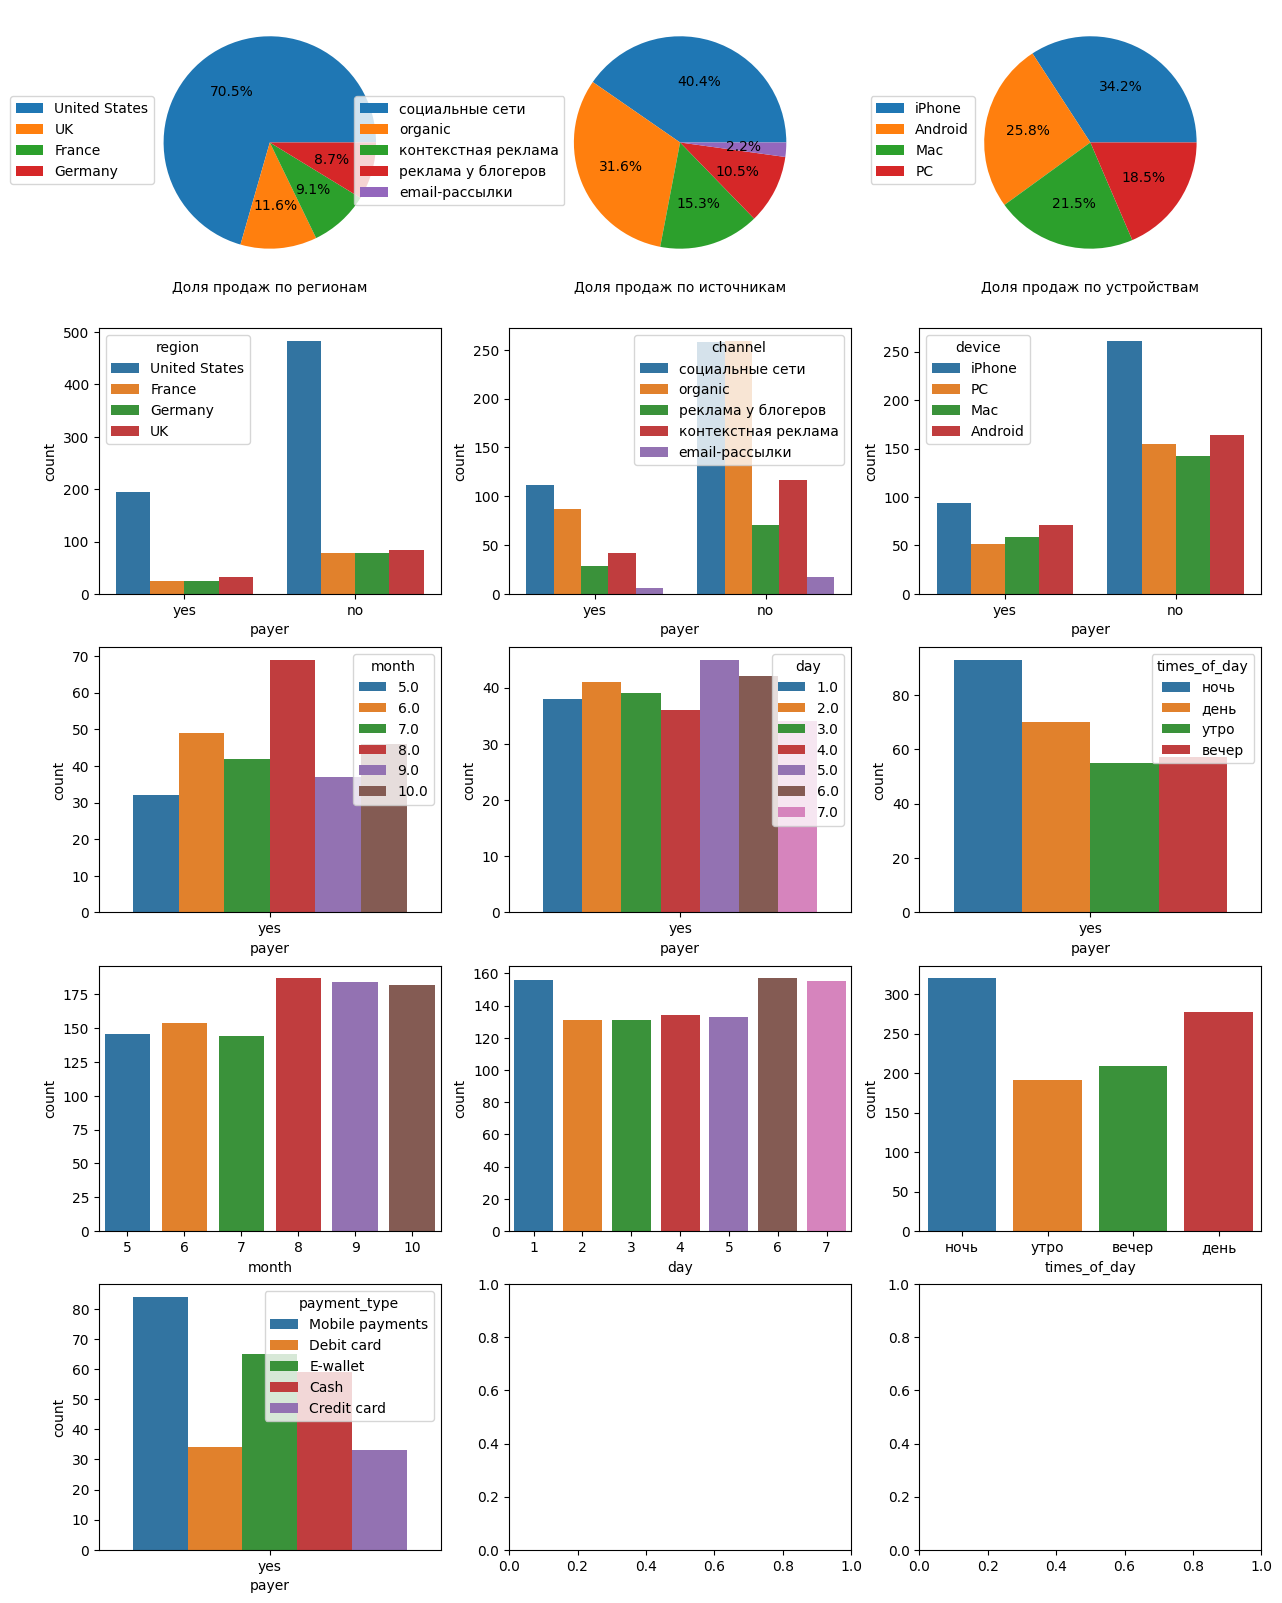

In [ ]:
# Провести аналитический и графический анализ данных:
cols = 3
rows = 5
fig, axs = plt.subplots(rows, cols, figsize=(15, 20))

df_payer = df.where(df['revenue'] > 0).dropna()

# Графики: Доля продаж по регионам, Доля продаж по источникам, Доля продаж по устройствам
pie_region = dict(df_payer['region'].value_counts())
pie_channel = dict(df_payer['channel'].value_counts())
pie_device = dict(df_payer['device'].value_counts())
axs[0, 0].pie(pie_region.values(), autopct='%1.1f%%')
axs[0, 0].legend(labels=pie_region.keys(), bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25))
axs[0, 0].set_xlabel('Доля продаж по регионам')
axs[0, 1].pie(pie_channel.values(), autopct='%1.1f%%')
axs[0, 1].legend(labels=pie_channel.keys(), bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25))
axs[0, 1].set_xlabel('Доля продаж по источникам')
axs[0, 2].pie(pie_device.values(), autopct='%1.1f%%')
axs[0, 2].legend(labels=pie_device.keys(), bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25))
axs[0, 2].set_xlabel('Доля продаж по устройствам')

# Графики: Количество пользователей с разбивкой на платящих/не платящих по регионам, Количество пользователей с разбивкой на платящих/не платящих по устройствам
# Количество пользователей с разбивкой на платящих/не платящих по источникам
df_intermediate = df.drop_duplicates(subset=['user_id'])
sns.countplot(data=df_intermediate, hue='region', x='payer', ax=axs[1, 0])
sns.countplot(data=df_intermediate, hue='channel', x='payer', ax=axs[1, 1])
sns.countplot(data=df_intermediate, hue='device', x='payer', ax=axs[1, 2])

# Графики, показывающие есть ли сезонность в продажах по месяцам, дням недели, времени суток
sns.countplot(data=df_payer, hue='month', x='payer', ax=axs[2, 0])
sns.countplot(data=df_payer, hue='day', x='payer', ax=axs[2, 1])
sns.countplot(data=df_payer, hue='times_of_day', x='payer', ax=axs[2, 2])

# Графики, показывающие есть ли сезонность в посещении сайта по месяцам, дням недели, времени суток
sns.countplot(data=df, x='month', ax=axs[3, 0])
sns.countplot(data=df, x='day', ax=axs[3, 1])
sns.countplot(data=df, x='times_of_day', ax=axs[3, 2])

# Диаграмма количества покупок по типу оплаты
sns.countplot(data=df_payer, hue='payment_type', x='payer', ax=axs[4, 0])

plt.show()


# **Проведение расчётов**

## Средний чек и среднее количества покупок на одного человека

In [ ]:
# Рассчитать средний чек.
df_payer = df.where(df['revenue'] > 0).dropna()
average_bill = df_payer['revenue'].mean()
print(f'Средний чек: {round(average_bill, 2)}')

Средний чек: 5529.92


In [ ]:
# Сколько покупок в среднем совершает 1 пользователь?

df_payer = df.where(df['revenue'] > 0).dropna()
user_payer = list(set(df_payer['user_id']))
number_of_user_purchases = []
for user_id in user_payer:
  x = df_payer.loc[df['user_id'] == user_id, 'sessiondurationsec'].shape[0]
  number_of_user_purchases.append(x)
number_of_user_purchases += [0] * (df.shape[0] - len(number_of_user_purchases))
average_number_of_purchases = sum(number_of_user_purchases) / len(number_of_user_purchases)
print(f'В среднем 1 пользователь совершает покупок: {round(average_number_of_purchases, 3)}')

В среднем 1 пользователь совершает покупок: 0.276


## Средняя продолжительность сессии по рекламным каналам и по типу устройства

Так как у нас очень большой разброс данных (например один пользователь зашел на сайт на 3 секунды, а другой провел там 2 часа), то вместо среднего будем использовать медиану

In [ ]:
# Рассчитать среднюю продолжительность сессии по рекламным каналам.
df['average_session_duration_sec_channels'] = df.groupby(['channel'])['sessiondurationsec'].transform(lambda x: x.median())
df_av_session_duration_channels = df[['channel', 'average_session_duration_sec_channels']]
df_av_session_duration_channels = df_av_session_duration_channels.drop_duplicates(ignore_index=True)
df_av_session_duration_channels

,channel,average_session_duration_sec_channels
0,социальные сети,1181.00
1,organic,1161.50
2,реклама у блогеров,1191.25
3,контекстная реклама,1255.00
4,email-рассылки,1150.00


In [ ]:
# Рассчитать среднюю продолжительность сессии по типу устройства.
df['average_session_duration_sec_device'] = df.groupby(['device'])['sessiondurationsec'].transform(lambda x: x.median())
df_av_session_duration_device = df[['device', 'average_session_duration_sec_device']]
df_av_session_duration_device = df_av_session_duration_device.drop_duplicates(ignore_index=True)
df_av_session_duration_device

,device,average_session_duration_sec_device
0,iPhone,1181.00
1,PC,1155.75
2,Mac,1255.00
3,Android,1299.00


## Топ-3 рекламных канала, региона и месяцев по регионам по среднему чеку

In [ ]:
# Определить топ-3 рекламных канала по среднему чеку.
df['average_bill_channel'] = df.groupby(['channel'])['revenue'].transform(lambda x: x.mean())
df_average_bill_channel = df[['channel', 'average_bill_channel']]
df_average_bill_channel = df_average_bill_channel.drop_duplicates(ignore_index=True)
df_average_bill_channel = df_average_bill_channel.sort_values(by=['average_bill_channel'], ascending=False)
df_average_bill_channel

,channel,average_bill_channel
0,социальные сети,5629.648649
1,organic,5527.758621
4,email-рассылки,5499.000000
2,реклама у блогеров,5447.275862
3,контекстная реклама,5332.333333


Из таблицы видно что в топ-3 рекламных канала по среднему чеку входят Социальные сети, organic и email-рассылки

In [ ]:
# Определить топ-3 региона по среднему чеку.
df['average_bill_region'] = df.groupby(['region'])['revenue'].transform(lambda x: x.mean())
df_average_bill_region = df[['region', 'average_bill_region']]
df_average_bill_region = df_average_bill_region.drop_duplicates(ignore_index=True)
df_average_bill_region = df_average_bill_region.sort_values(by=['average_bill_region'], ascending=False)
df_average_bill_region

,region,average_bill_region
3,UK,5624.000000
0,United States,5540.257732
2,Germany,5499.000000
1,France,5359.000000


Из таблицы видно что в топ-3 региона по среднему чеку входят UK,	United States и Germany

In [ ]:
# Определить топ-3 месяца по среднему чеку с разбивкой по регионам.
df['average_bill_region_month'] = df.groupby(['region', 'month'])['revenue'].transform(lambda x: x.mean())
df_average_bill_region_month = df[['region', 'month', 'average_bill_region_month']]
df_average_bill_region_month = df_average_bill_region_month.drop_duplicates(ignore_index=True)
df_average_bill_region_month = df_average_bill_region_month.sort_values(by=['region', 'average_bill_region_month'], ascending=False)
df_average_bill_region_month

,region,month,average_bill_region_month
0,United States,5,5825.260870
13,United States,8,5743.680851
5,United States,6,5665.666667
16,United States,9,5356.142857
8,United States,7,5351.941176
20,United States,10,5280.250000
22,UK,10,6141.857143
14,UK,8,5776.777778
3,UK,5,5499.000000
4,UK,6,5427.571429


Из таблицы видно что в топ-3 месяца по среднему чеку с разбивкой по регионам:
Для United States: май, август, июнь (5, 8, 6)
Для UK: октябрь, август, май (10, 8, 5)
Для Germany: июль, июнь, сентябрь (7, 6, 9)
Для France: июнь, май, октябрь (6, 5, 10)

## MAU и таблица с MAU

In [ ]:
df_organic = df.loc[df['channel'] == 'organic']
users_id_old = set()
users_id_new_organic = []
users_id_new_organic_pay = []
for i in range(5, 11):
  cnt = 0
  k = 0
  users_id = set(df_organic.loc[df['month'] == i, 'user_id'])
  for elem in users_id:
    if elem not in users_id_old:
      cnt += 1
      if 'yes' in set(df.loc[df['user_id'] == elem, 'payer']):
        k += 1
      users_id_old.add(elem)
  users_id_new_organic.append(cnt)
  users_id_new_organic_pay.append(k)
sales_amount_organic = sum(df_organic.loc[df_organic['revenue'] > 0, 'revenue'])

df_social_network = df.loc[df['channel'] == 'социальные сети']
users_id_old = set()
users_id_new_social_network = []
users_id_new_social_network_pay = []
for i in range(5, 11):
  cnt = 0
  k = 0
  users_id = set(df_social_network.loc[df['month'] == i, 'user_id'])
  for elem in users_id:
    if elem not in users_id_old:
      cnt += 1
      if 'yes' in set(df.loc[df['user_id'] == elem, 'payer']):
        k += 1
      users_id_old.add(elem)
  users_id_new_social_network.append(cnt)
  users_id_new_social_network_pay.append(k)
sales_amount_social_networkc = sum(df_social_network.loc[df_social_network['revenue'] > 0, 'revenue'])

df_blogger_advertising = df.loc[df['channel'] == 'реклама у блогеров']
users_id_old = set()
users_id_new_blogger_advertising = []
users_id_new_blogger_advertising_pay = []
for i in range(5, 11):
  cnt = 0
  k = 0
  users_id = set(df_blogger_advertising.loc[df['month'] == i, 'user_id'])
  for elem in users_id:
    if elem not in users_id_old:
      cnt += 1
      if 'yes' in set(df.loc[df['user_id'] == elem, 'payer']):
        k += 1
      users_id_old.add(elem)
  users_id_new_blogger_advertising.append(cnt)
  users_id_new_blogger_advertising_pay.append(k)
sales_amount_blogger_advertising = sum(df_blogger_advertising.loc[df_blogger_advertising['revenue'] > 0, 'revenue'])

df_email_newsletters = df.loc[df['channel'] == 'email-рассылки']
users_id_old = set()
users_id_new_email_newsletters = []
users_id_new_email_newsletters_pay = []
for i in range(5, 11):
  cnt = 0
  k = 0
  users_id = set(df_email_newsletters.loc[df['month'] == i, 'user_id'])
  for elem in users_id:
    if elem not in users_id_old:
      cnt += 1
      if 'yes' in set(df.loc[df['user_id'] == elem, 'payer']):
        k += 1
      users_id_old.add(elem)
  users_id_new_email_newsletters.append(cnt)
  users_id_new_email_newsletters_pay.append(k)
sales_amount_email_newsletters = sum(df_email_newsletters.loc[df_email_newsletters['revenue'] > 0, 'revenue'])

df_contextual_advertising = df.loc[df['channel'] == 'контекстная реклама']
users_id_old = set()
users_id_contextual_advertising = []
users_id_contextual_advertising_pay = []
for i in range(5, 11):
  cnt = 0
  k = 0
  users_id = set(df_contextual_advertising.loc[df['month'] == i, 'user_id'])
  for elem in users_id:
    if elem not in users_id_old:
      cnt += 1
      if 'yes' in set(df.loc[df['user_id'] == elem, 'payer']):
        k += 1
      users_id_old.add(elem)
  users_id_contextual_advertising.append(cnt)
  users_id_contextual_advertising_pay.append(k)
sales_amount_contextual_advertising = sum(df_contextual_advertising.loc[df_contextual_advertising['revenue'] > 0, 'revenue'])

matr = pd.DataFrame({'социальные сети': users_id_new_social_network_pay, 'organic': users_id_new_organic_pay, 'контекстная реклама': users_id_contextual_advertising_pay, 'реклама у блогеров': users_id_new_blogger_advertising_pay, 'email-рассылки': users_id_new_email_newsletters_pay})
matr = np.array(matr)
df_number_of_unique_users = pd.DataFrame({'organic': users_id_new_organic, 'социальные сети': users_id_new_social_network, 'контекстная реклама': users_id_contextual_advertising, 'реклама у блогеров': users_id_new_blogger_advertising, 'email-рассылки': users_id_new_email_newsletters})
df_number_of_unique_users = df_number_of_unique_users.T
df_number_of_unique_users.columns = [5, 6, 7, 8, 9, 10]
df_number_of_unique_users['количество пользователей'] = df_number_of_unique_users.sum(axis=1)
df_number_of_unique_users = df_number_of_unique_users.sort_values(by=['количество пользователей'], ascending=False)
number_of_users = np.array(df_number_of_unique_users['количество пользователей'])
df_number_of_unique_users['5_payer'] = matr[0]
df_number_of_unique_users['6_payer'] = matr[1]
df_number_of_unique_users['7_payer'] = matr[2]
df_number_of_unique_users['8_payer'] = matr[3]
df_number_of_unique_users['9_payer'] = matr[4]
df_number_of_unique_users['10_payer'] = matr[5]
matr = matr.T
number_of_paying_users = [sum(elem) for elem in matr]
conversion = [round(number_of_paying_users[i] / number_of_users[i] * 100, 2) for i in range(len(number_of_users))]
df_number_of_unique_users['количество платящих пользователей'] = number_of_paying_users
df_number_of_unique_users['конверсия'] = conversion
sales_amounts = [sales_amount_social_networkc, sales_amount_organic, sales_amount_contextual_advertising, sales_amount_blogger_advertising, sales_amount_email_newsletters]
df_number_of_unique_users['сумма продаж'] = sales_amounts
df_number_of_unique_users

,5,6,7,8,9,10,количество пользователей,5_payer,6_payer,7_payer,8_payer,9_payer,10_payer,количество платящих пользователей,конверсия,сумма продаж
социальные сети,41,53,56,68,66,85,369,10,14,21,24,17,25,111,30.08,624891.0
organic,76,59,46,60,58,47,346,13,20,13,23,10,8,87,25.14,480915.0
контекстная реклама,8,28,24,35,38,26,159,1,9,4,14,7,7,42,26.42,223958.0
реклама у блогеров,14,13,15,20,20,18,100,6,5,4,7,3,4,29,29.00,157971.0
email-рассылки,7,1,3,4,2,6,23,2,1,0,1,0,2,6,26.09,32994.0


Из таблицы видно, что топ-3 рекламных каналов по количеству уникальных пользователей в месяц это: социальные сети, organic, контекстная реклама. Organic даёт очень хорошие показатели, учитывая что мы не тратим на него денег. Социальные сети дает самый лучший показатель, но они самые дорогие после контекстной рекламы.
Также из таблицы видно, что больше всего платящих пользователей и наибольшую сумму продаж принесли социальные сети.

# **Проверка гипотез**

## Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

In [ ]:

df1 = pd.DataFrame(df[['sessiondurationsec', 'revenue']].copy()).dropna()
print(df1.head())
g1 = df1['sessiondurationsec']
g2 = df1['revenue']
#проверка на нормальность
if shapiro(g1)[1] >= 0.05 and shapiro(g2)[1] >= 0.05:
    # корреляция Пирсона
    print(round(pearsonr(df1['sessiondurationsec'], df1['revenue']).pvalue, 4), "Пирсон")
else:
    # корреляция Спирмена
    print(round(spearmanr(df1['sessiondurationsec'], df1['revenue']).pvalue, 4), "Спирмен")

    sessiondurationsec  revenue
0                 26.0   9999.0
20               240.0   4999.0
28              4177.0   4999.0
33                47.0   4999.0
34               306.0   4999.0
0.3415 Спирмен


pvalue > 0.05 => взаимосвязи между продолжительностью сессии с суммой покупок нет

## Средний чек отличается в зависимости от региона

In [ ]:

df2 = pd.DataFrame(df[['region', 'revenue']].copy()).dropna()
g1 = df2[df2['region'] == 'United States']['revenue']
g2 = df2[df2['region'] == 'Germany']['revenue']
g3 = df2[df2['region'] == 'France']['revenue']
g4 = df2[df2['region'] == 'UK']['revenue']
# проверка на нормальность
if (shapiro(g1)[1] >= 0.05) and (shapiro(g2)[1] >= 0.05) and (shapiro(g3)[1] >= 0.05) and (shapiro(g4)[1] >= 0.05):
    # anova
    print(f_oneway(g1, g2, g3, g4).pvalue < 0.05)
    print(f_oneway(g1, g2, g3, g4).pvalue)
else:
    # критерий Краскела-Уоллеса
    print(kruskal(g1, g2, g3, g4).pvalue < 0.05)
    print(kruskal(g1, g2, g3, g4).pvalue)

False
0.7537856046598209


pvalue > 0.05 => чек не отличается в зависимости от региона

## Средний чек отличается в зависимости от рекламного канала

In [ ]:

df4 = pd.DataFrame(df[['channel', 'revenue']].copy()).dropna()
grp1 = df4[df4['channel'] == 'социальные сети']['revenue']
grp2 = df4[df4['channel'] == 'organic']['revenue']
grp3 = df4[df4['channel'] == 'реклама у блогеров']['revenue']
grp4 = df4[df4['channel'] == 'email-рассылки']['revenue']
grp5 = df4[df4['channel'] == 'контекстная реклама']['revenue']
# проверка на нормальность
if (shapiro(g1)[1] >= 0.05) and (shapiro(g2)[1] >= 0.05) and (shapiro(g3)[1] >= 0.05) and (shapiro(g4)[1] >= 0.05):
    # anova
    print(f_oneway(grp1, grp2, grp3, grp4).pvalue < 0.05)
    print(f_oneway(grp1, grp2, grp3, grp4).pvalue)
else:
    # критерий Краскела-Уоллеса
    print(kruskal(grp1, grp2, grp3, grp4).pvalue < 0.05)
    print(kruskal(grp1, grp2, grp3, grp4).pvalue)

False
0.8827095231043185


pvalue > 0.05 => чек не отличается в зависимости от рекламного канала

## Средний чек отличается в зависимости от времени суток

In [ ]:

df5 = pd.DataFrame(df[['times_of_day', 'revenue']].copy()).dropna()
grup1 = df5[df5['times_of_day'] == 'день']['revenue']
grup2 = df5[df5['times_of_day'] == 'вечер']['revenue']
grup3 = df5[df5['times_of_day'] == 'утро']['revenue']
grup4 = df5[df5['times_of_day'] == 'ночь']['revenue']
# проверка на нормальность
if (shapiro(g1)[1] >= 0.05) and (shapiro(g2)[1] >= 0.05) and (shapiro(g3)[1] >= 0.05) and (shapiro(g4)[1] >= 0.05):
    # anova
    print(f_oneway(grup1, grup2, grup3, grup4).pvalue < 0.05)
    print(f_oneway(grup1, grup2, grup3, grup4).pvalue)
else:
    # критерий Краскела-Уоллеса
    print(kruskal(grup1, grup2, grup3, grup4).pvalue < 0.05)
    print(kruskal(grup1, grup2, grup3, grup4).pvalue)

False
0.5063452619465103


pvalue > 0.05 => чек не отличается в зависимости от времени суток

## Влияет ли рекламный канал на продолжительность сессии?

In [ ]:

df4 = pd.DataFrame(df[['channel', 'sessiondurationsec']].copy()).dropna()
grupp1 = df4[df4['channel'] == 'социальные сети']['sessiondurationsec']
grupp2 = df4[df4['channel'] == 'organic']['sessiondurationsec']
grupp3 = df4[df4['channel'] == 'реклама у блогеров']['sessiondurationsec']
grupp4 = df4[df4['channel'] == 'email-рассылки']['sessiondurationsec']
grupp5 = df4[df4['channel'] == 'контекстная реклама']['sessiondurationsec']
# проверка на нормальность
if (shapiro(grupp1)[1] >= 0.05) and (shapiro(grupp2)[1] >= 0.05) and (shapiro(grupp3)[1] >= 0.05) and (shapiro(grupp4)[1] >= 0.05) and (shapiro(grupp5)[1] >= 0.05):
    # anova
    print(f_oneway(grupp1, grupp2, grupp3, grupp4, grupp5).pvalue < 0.05)
    print(f_oneway(grupp1, grupp2, grupp3, grupp4, grupp5).pvalue)
else:
    # критерий Краскела-Уоллеса
    print(kruskal(grupp1, grupp2, grupp3, grupp4, grupp5).pvalue < 0.05)
    print(kruskal(grupp1, grupp2, grupp3, grupp4, grupp5).pvalue)

False
0.3663208672285452


pvalue >= 0.05 => рекламный канал не влияет на продолжительность сессии

## Влияет ли тип устройства на количество покупок в день по каждому региону?

In [ ]:

# удаление пользователей, не совершивших покупки
df01 = pd.DataFrame(df.copy()).dropna(subset=['order_dt'])
days = df01['session_date'].unique()
devices = df01['device'].unique()
days1 = []
for x in range(len(days)):
    for i in range(len(devices)):
        days1.append(days[x])

devices1 = []
for x in range(len(days)):
    for el in devices:
      devices1.append(el)
for reg in regions:
    orders = []
    for i in range(len(days1)):
        orders.append(len(df01[(df01['device'] == devices1[i]) &
         (df01['region'] == reg) & (df01['session_date'] == days1[i])]))
    # создание таблицы с количеством покупок по дням с определенного устройства по региону
    df3 = pd.DataFrame({'day': days1, 'device': devices1, 'number_of_orders': orders})
    gr1 = df3['number_of_orders'][df3['device'] == 'iPhone']
    gr2 = df3['number_of_orders'][df3['device'] == 'PC']
    gr3 = df3['number_of_orders'][df3['device'] == 'Mac']
    gr4 = df3['number_of_orders'][df3['device'] == 'Android']
    # проверка на нормальность
    if (shapiro(gr1)[1] >= 0.05) and (shapiro(gr2)[1] >= 0.05) and (shapiro(gr3)[1] >= 0.05) and (shapiro(gr4)[1] >= 0.05):
        # anova
        print(f_oneway(gr1, gr2, gr3, gr4).pvalue < 0.05)
        print(f_oneway(gr1, gr2, gr3, gr4).pvalue)
        print(reg)
        print(df3.head())
    else:
        # критерий Краскела-Уоллеса
        print(kruskal(gr1, gr2, gr3, gr4).pvalue < 0.05)
        print(kruskal(gr1, gr2, gr3, gr4).pvalue)
        print(reg)
        print(df3.head())

False
0.5532297002984046
Germany
         day   device  number_of_orders
0 2019-05-01   iPhone                 0
1 2019-05-01  Android                 0
2 2019-05-01      Mac                 0
3 2019-05-01       PC                 0
4 2019-05-06   iPhone                 0
True
5.502706464720504e-07
United States
         day   device  number_of_orders
0 2019-05-01   iPhone                 1
1 2019-05-01  Android                 0
2 2019-05-01      Mac                 0
3 2019-05-01       PC                 0
4 2019-05-06   iPhone                 0
False
0.13887024880499224
France
         day   device  number_of_orders
0 2019-05-01   iPhone                 0
1 2019-05-01  Android                 0
2 2019-05-01      Mac                 0
3 2019-05-01       PC                 0
4 2019-05-06   iPhone                 0
False
0.30323416812902076
UK
         day   device  number_of_orders
0 2019-05-01   iPhone                 0
1 2019-05-01  Android                 0
2 2019-05-01      Mac   

в Америке тип устройства влияет на количество покупок в день

## Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

In [ ]:

# удаление пользователей, не совершивших покупки
df01 = pd.DataFrame(df.copy()).dropna(subset=['order_dt'])
days = df01['session_date'].unique()
channels = df01['channel'].unique()
days2 = []
for x in range(len(days)):
    for i in range(len(channels)):
        days2.append(days[x])

channels1 = []
for x in range(len(days)):
    for el in channels:
      channels1.append(el)
for reg in regions:
    orders = []
    for i in range(len(days2)):
        orders.append(len(df01[(df01['channel'] == channels1[i]) &
         (df01['region'] == reg) & (df01['session_date'] == days2[i])]))
    # создание таблицы с количеством покупок по дням с определенным рекламным каналом по региону
    df3 = pd.DataFrame({'day': days2, 'channel': channels1, 'number_of_orders': orders})
    gr1 = df3['number_of_orders'][df3['channel'] == 'социальные сети']
    gr2 = df3['number_of_orders'][df3['channel'] == 'organic']
    gr3 = df3['number_of_orders'][df3['channel'] == 'реклама у блогеров']
    gr4 = df3['number_of_orders'][df3['channel'] == 'email-рассылки']
    gr5 = df3['number_of_orders'][df3['channel'] == 'контекстная реклама']
    # проверка на нормальность
    if (shapiro(gr1)[1] >= 0.05) and (shapiro(gr2)[1] >= 0.05) and (shapiro(gr3)[1] >= 0.05) and (shapiro(gr4)[1] >= 0.05):
        # anova
        print(f_oneway(gr1, gr2, gr3, gr4).pvalue < 0.05)
        print(f_oneway(gr1, gr2, gr3, gr4).pvalue)
        print(reg)
        print(df3.head())
    else:
        # критерий Краскела-Уоллеса
        print(kruskal(gr1, gr2, gr3, gr4).pvalue < 0.05)
        print(kruskal(gr1, gr2, gr3, gr4).pvalue)
        print(reg)
        print(df3.head())

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


True
0.01251688001709667
Germany
         day              channel  number_of_orders
0 2019-05-01      социальные сети                 0
1 2019-05-01              organic                 0
2 2019-05-01   реклама у блогеров                 0
3 2019-05-01       email-рассылки                 0
4 2019-05-01  контекстная реклама                 0
True
9.545816114016378e-32
United States
         day              channel  number_of_orders
0 2019-05-01      социальные сети                 1
1 2019-05-01              organic                 0
2 2019-05-01   реклама у блогеров                 0
3 2019-05-01       email-рассылки                 0
4 2019-05-01  контекстная реклама                 0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


False
0.050397361719587974
France
         day              channel  number_of_orders
0 2019-05-01      социальные сети                 0
1 2019-05-01              organic                 0
2 2019-05-01   реклама у блогеров                 0
3 2019-05-01       email-рассылки                 0
4 2019-05-01  контекстная реклама                 0
True
0.016007604413047428
UK
         day              channel  number_of_orders
0 2019-05-01      социальные сети                 0
1 2019-05-01              organic                 0
2 2019-05-01   реклама у блогеров                 0
3 2019-05-01       email-рассылки                 0
4 2019-05-01  контекстная реклама                 0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Во всех регионах, кроме Франции, тип рекламного канала влияет на количество покупок в день

## Гипотеза о том, что определенный рекламный канал привлекает пользователей определенных устройств

In [ ]:
cross_matrix = pd.crosstab(df['channel'], df['device'])
print(chi2_contingency(cross_matrix)[1] < 0.05)
print(chi2_contingency(cross_matrix)[1])

True
1.5206103017569729e-13


pvalue < 0.05 => определенный рекламный канал привлекает пользователей определенных устройств

# **Подготовка данных для линейной регрессии**

## Подготовка данных для линейной регрессии

In [ ]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(sparse_output=False)


def get_ohe(data, categs):
    """
    Функция для ohe_категоризации необходимых столбцов и последующего объединения с количественными столбцами
    """
    temp_df = pd.DataFrame(
        data=ohe.transform(data[categs]), columns=ohe.get_feature_names_out()
    )
    data = pd.concat([data.reset_index(drop=True), temp_df], axis=1)
    data = data.drop(columns=categs, axis=1)
    data.columns = data.columns.str.lower().str.replace(" ", "_")
    return data

In [ ]:
from scipy.stats import spearmanr, mannwhitneyu, pearsonr, shapiro, ttest_ind, f_oneway


def correlation_ratio(categories, values):
    """
    Расчёт корреляции через отношение дисперсий
    Eta
    """
    categories = np.array(categories)
    values = np.array(values)

    ssw = 0
    ssb = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ssw += sum((subgroup - np.mean(subgroup)) ** 2)
        ssb += len(subgroup) * (np.mean(subgroup) - np.mean(values)) ** 2
    return (ssb / (ssb + ssw)) ** 0.5

In [ ]:
# делаем One Hot Encoding и преводим в порядок promo_code
ohe_columns = ["channel", "payment_type", "device", "region"]
ohe.fit(df[ohe_columns])
linreg_df = get_ohe(df, ohe_columns)
linreg_df["promo_code"] = linreg_df["promo_code"].apply(
    lambda pc: 1 if pc != np.nan and pc != 0.0 else 0
)
linreg_df = linreg_df.dropna()


In [ ]:
shapiro(linreg_df["amount_including_discount"])[1] >= 0.05
# amount_including_discount распределен ненормально значит будем использовать коэффициент Спирмена

False

In [ ]:
amount_including_discount = linreg_df["amount_including_discount"]
correlations = list()

for col in linreg_df.columns:
    other_column = linreg_df[col]
    if other_column.dtype == "object":
        v = correlation_ratio(other_column, amount_including_discount)
        correlations.append((("amount_including_discount", col), (v, "Nan"), "Eta"))
    else:
        v = spearmanr(other_column, revenue)
        correlations.append(
            (("amount_including_discount", col), (v.statistic, v.pvalue), "Спирмен")
        )
correlations.sort(key=lambda s: abs(s[1][0]), reverse=True)
for row in correlations:
    print(*row)


NameError: ignored

Отсюда нельзя увидеть какие-либо нормальной закономерности, поэтому

попробуем просуммировать значения столбцов по дням

In [ ]:
  linreg_df.columns

Index(['user_id', 'session_start', 'session_end', 'sessiondurationsec',
       'session_date', 'month', 'day', 'hour_of_day', 'order_dt', 'revenue',
       'promo_code', 'amount_including_discount', 'times_of_day', 'payer',
       'average_session_duration_sec_channels',
       'average_session_duration_sec_device', 'channel_email-рассылки',
       'channel_organic', 'channel_контекстная_реклама',
       'channel_реклама_у_блогеров', 'channel_социальные_сети',
       'payment_type_cash', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_e-wallet',
       'payment_type_mobile_payments', 'payment_type_nan', 'device_android',
       'device_mac', 'device_pc', 'device_iphone', 'region_france',
       'region_germany', 'region_uk', 'region_united_states'],
      dtype='object')

Выберем величины, которые могут влиять на сумму, и на которые мы можем повлиять некоторым образом. Также возьмём месяц, предполагая возможную сезонность. Возьмём "channel", "device", "month", "region", "promo_code", "sessiondurationsec"

In [ ]:
param = {
    "amount_including_discount": "sum",
    "channel_email-рассылки" : "sum",
    "channel_organic": "sum",
    "channel_контекстная_реклама": "sum",
    "channel_реклама_у_блогеров": "sum",
    "channel_социальные_сети": "sum",
    "device_mac": "sum",
    "device_pc": "sum",
    "device_iphone": "sum",
    "device_android": "sum",
    "region_france": "sum",
    "region_germany": "sum",
    "region_uk": "sum",
    "region_united_states": "sum",
    "sessiondurationsec": "sum",
    "promo_code" : "sum",
    "month": "first",
}

df_by_day = linreg_df.groupby("session_date").agg(param)

df_by_day = pd.get_dummies(df_by_day, columns=['month', ])

In [ ]:
df_by_day

,amount_including_discount,channel_email-рассылки,channel_organic,channel_контекстная_реклама,channel_реклама_у_блогеров,channel_социальные_сети,device_mac,device_pc,device_iphone,device_android,...,region_uk,region_united_states,sessiondurationsec,promo_code,month_5,month_6,month_7,month_8,month_9,month_10
session_date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,9999.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,26.000000,0,1,0,0,0,0,0
2019-05-06,4999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,240.000000,0,1,0,0,0,0,0
2019-05-07,4499.1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4177.000000,1,1,0,0,0,0,0
2019-05-09,9498.1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,2.0,353.000000,1,1,0,0,0,0,0
2019-05-12,4999.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,5028.000000,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-25,14997.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,...,0.0,3.0,1397.000000,0,0,0,0,0,0,1
2019-10-26,11998.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,...,1.0,1.0,4418.000001,0,0,0,0,0,0,1
2019-10-27,30995.0,2.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,...,2.0,1.0,8108.000001,0,0,0,0,0,0,1


<Axes: >

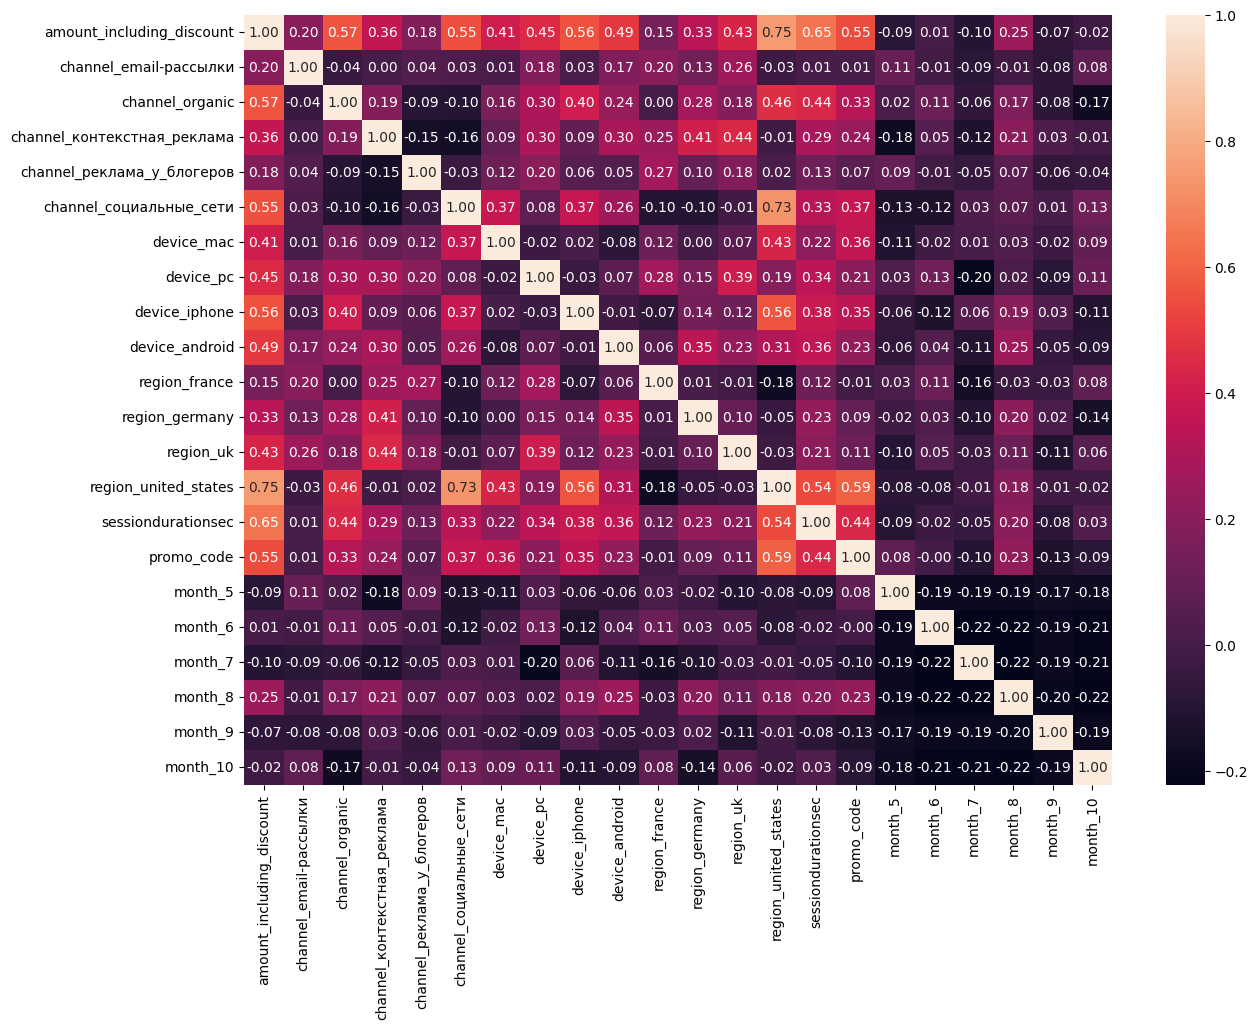

In [ ]:
correlations = list()
plt.rcParams['figure.figsize'] = 14,10
sns.heatmap(df_by_day.corr(), annot=True, fmt="0.2f")


Из карты корреляции, можно увидеть, что "month_7", "month_5", "month_10", "month_9", "month_6" слишком слабо коррелируют с "amount_including_discount", поэтому их можно удалить.

Заметим, что "channel_социальные_сети", "channel_organic", "device_mac", "device_iphone", "sessiondurationsec", "promo_code" достаточно коррелируют как между собой, так и c "region_united_states", поэтому удаляем их, но "region_united_states" оставляем.

In [ ]:

df_by_day = df_by_day.drop(
    [
        "channel_социальные_сети",
        "channel_organic",
        "device_mac",
        "device_iphone",
        "sessiondurationsec",
        "promo_code",
        "month_7",
        "month_5",
        "month_10",
        "month_9",
        "month_6",
    ],
    axis=1,
)

## Обучение регрессии

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error

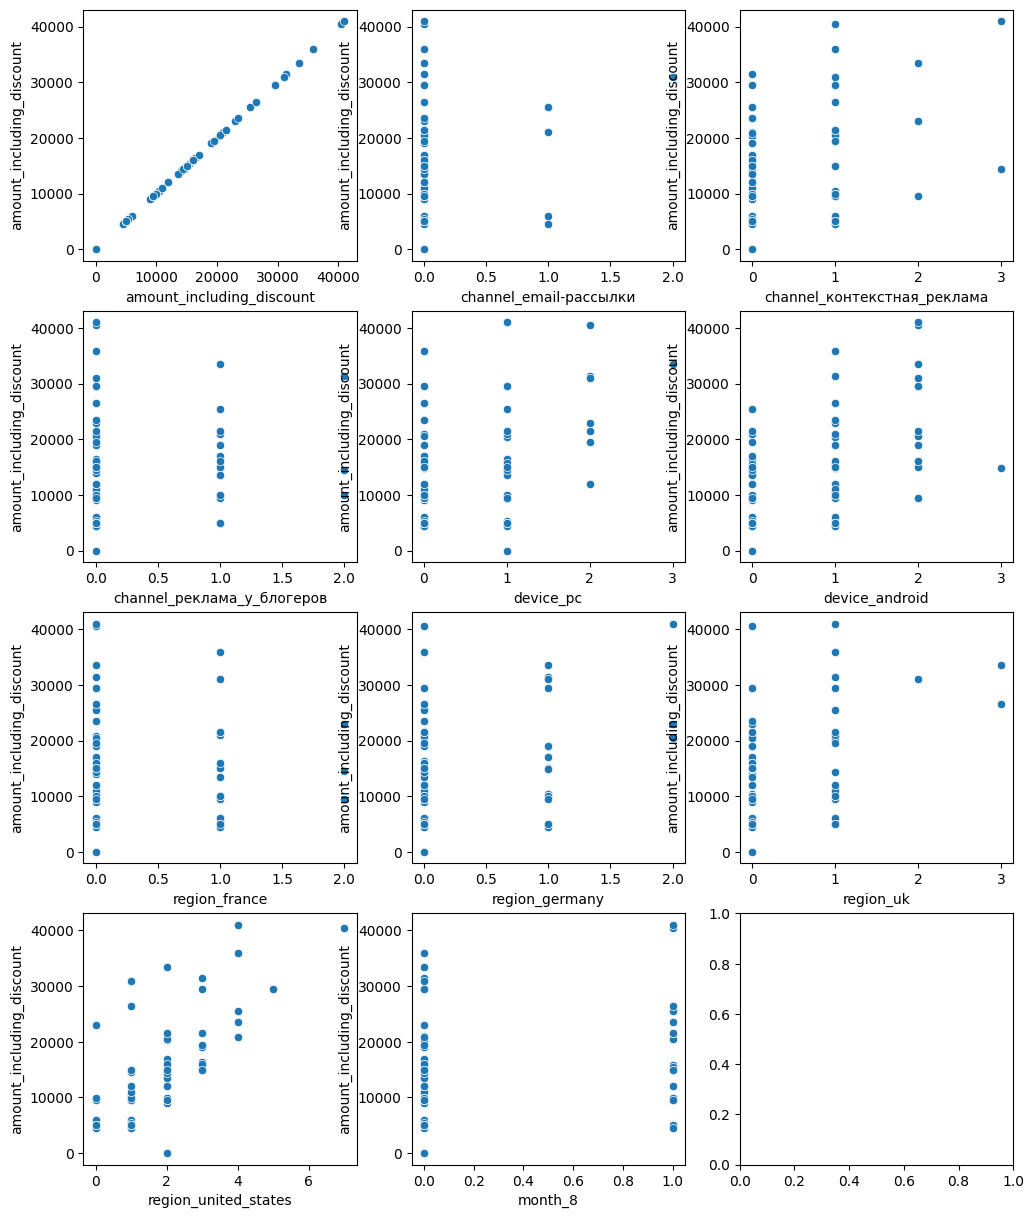

In [ ]:
fig, axes = plt.subplots(len(df_by_day.columns)//3 + 1, 3, figsize=(12, 15))
for i, col in enumerate(df_by_day.columns):
  sns.scatterplot(x=df_by_day[col], y=df_by_day["amount_including_discount"], ax=axes[i//3][i%3])

Построим диаграмму рассеянности, чтобы изучить зависимость между величинами. Отметим, что факторы в основном имеют 2-3 уникальных значения. Визуально сложно определить наличие зависимости. Доверимся ранее полученным коэффициентам корреляции.

In [ ]:
# разделям данные на обучающие и тестовые
X = df_by_day.drop(["amount_including_discount"], axis=1)
y = df_by_day["amount_including_discount"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# обучаем регрессию
linreg = LinearRegression()
linreg.fit(X_train, y_train)
preds = linreg.predict(X_test)
r2 = round(r2_score(y_test, preds), 2)
mape_err = round(mean_absolute_percentage_error(y_test, preds)*100, 2)
print("R2", r2)
print("MAPE", str(mape_err)+"%")

R2 0.91
MAPE 10.46%


В качестве регрессионной модели возьмем линейную регрессию, потому что это самая простая, популярная и легко интерпретируемая модель. На выходе получаем следующие метрики:

*   R2 - 0.91
*   MAPE - 10.46%

То есть предсказания нашей модели сильно точнее, чем просто среднее, и в среднем отличаются от реальной величины на 10.5%.

In [ ]:
linreg.coef_, linreg.intercept_

(array([ -182.18959971, -1007.55428053,  -816.48358683,  -466.93702516,
          -54.93320982,  6276.61373602,  6743.41140491,  7200.67006674,
         5855.93594016,   217.28223348]),
 -890.709262555154)

Text(0.5, 0.98, 'Распределение остатков')

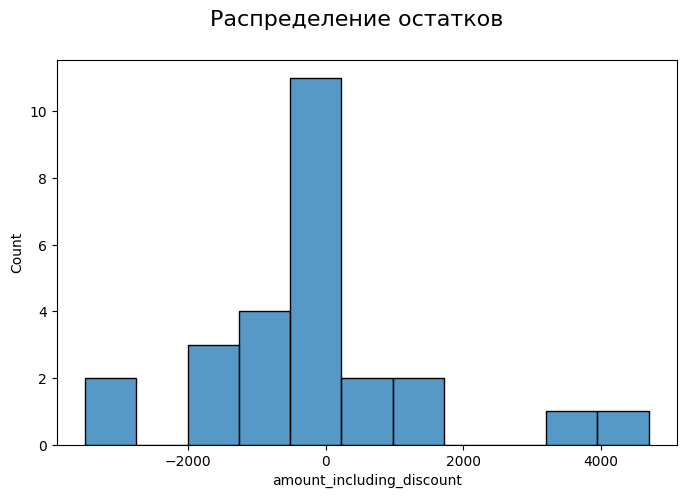

In [ ]:
plt.rcParams['figure.figsize'] = 8, 5
preds = linreg.predict(X_test)
residual = y_test - preds
rel = sns.histplot(residual)
rel.figure.suptitle(
    "Распределение остатков",
    fontsize=16,
)

##Выводы
Регрессионная модель для предсказания суммы продаж за день.<br>
Модель - линейная регрессия.<br>
Предсказывали сумму `"amount_including_discount"`, то есть сумму продаж с учётом скидок за день.

В качестве параметров было выбрано количество сессий за день с определённым значением факторы, то есть значение каждого фактора - количество сессий со значением факторы, указанные в названии фатора. <br>
Проведя корреляционный анализ факторов, в качестве параметров были выбраны следующие:
```
    "channel_email-рассылки"
    "channel_контекстная_реклама"
    "channel_реклама_у_блогеров"
    "device_pc"
    "device_android"
    "region_france"
    "region_germany"
    "region_uk"
    "region_united_states"
    "month_8"
```

**Метрики**
*   R2 - 0.91
*   MAPE - 10.46%

Отсюда, видно, что предсказания нашей модели сильно точнее, чем просто среднее, и в среднем отличаются от реальной величины на 10.5%.

**Как можно улучшить результаты?**
1. Провести тщательный выбор параметров(можно заметить, что у нас есть отрицательные коэффициенты в линейной регрессии, что странно, сначала можно убрать эти факторы)
2. Рассмотреть более сложные модели(например CatBoost, поскольку у нас много категориальных данных)
3. Увеличить объём данных для обучения модели

# **Дашборд: https://datalens.yandex/k6s7a7t8spsm9**